In [5]:
#!pip3 freeze > "../requirements.txt"
#!pip3 install -r "../requirements.txt"  # giving some error
from google.cloud import bigquery
import pandas as pd
import numpy as np
import pandas_gbq
import copy
import copy
import pickle
import datetime as dt
from datetime import timezone
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from pins import board_rsconnect
from collections import Counter
from IPython.display import display
from datetime import timedelta
import pytz
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500) 

def GBQ_data(query_string):
    client = bigquery.Client('turing-230020')
    query = client.query(query_string)
    results = query.result()
    return results.to_dataframe()

fss_data = pd.read_csv('clustered-data/fss-cluster-data-2022-08-16.csv', index_col=0)
fss_data = fss_data.loc[fss_data['cluster'].isin([0,1,2,3,4,5])]
fss_data['cluster'] = np.where(fss_data['cluster']==3, 4, fss_data['cluster'])
fss_data['cluster'] = np.where(fss_data['cluster'].isin([0,2]), 1, fss_data['cluster'])
fss_data['cluster'] = fss_data['cluster'].map({5:0, 1:1, 4:2})
#fss_data.groupby('cluster').agg({'job_id':'count', 'target':'mean',  'num_must_have_skills':'mean'})

ets_data = pd.read_csv('clustered-data/enterprise-cluster-data-2022-08-16.csv', index_col=0)
ets_data['cluster'] = ets_data['cluster'].map({1:0, 0:1, 2:2})

API_KEY = 'yDAssnMUtqatxoOpyNgYVKZcXfLP3vwD' 
SERVER = 'https://rstudio-connect.turing.com/'
board = board_rsconnect(server_url=SERVER, api_key=API_KEY)
job_data =board.pin_read("muhammad_usman/demand-basic-data")


In [ ]:
job_data_cols = ['job_id', 'client_category', 'created_date', 'dc_date', 'max_acceptable_rate', 'is_deleted',
                 'job_value', 'status', 'num_must_have_skills', 'must_have_total_years_of_experience',
                'ms_num_queries', 'ss_queries', 'queries', 'interviews_requested', 'interviews_scheduled',
                'interviews_happened','interviews_passed', 'interviews_failed', 'region', 'opportunity_created_date']

final_data = job_data[job_data_cols].copy()
final_data['created_date'] = pd.to_datetime(final_data['created_date'])
final_data['opportunity_created_date'] = pd.to_datetime(final_data['opportunity_created_date'])
final_data['dc_date'] = pd.to_datetime(final_data['dc_date'])
final_data['dc'] = np.where(final_data['dc_date'].isna(), 0,1)
final_data['ninety_days_old'] = np.where((final_data['created_date'] > dt.datetime.now(pytz.utc) - timedelta(days = 90)) & (final_data['dc']==0) , 1,0)
final_data['time_taken_DC'] = (final_data['dc_date'] - final_data['opportunity_created_date']).dt.days
#final_data['time_taken_DC'] = np.where(final_data['time_taken_DC']<0, 0, final_data['time_taken_DC'])
final_data['enterprise'] = np.where(final_data['client_category']=='1.Platinum', 1,0)
final_data['active'] = np.where(~(final_data['status'].isin(['Lost Opportunity', 'Project Aborted', 'Paused'])) & (final_data['dc']==0), 1,0)
final_data['lost'] = np.where((final_data['status'].isin(['Lost Opportunity', 'Project Aborted', 'Paused']) & (final_data['dc']==0)), 1,0)
final_data['max_acceptable_rate'] = np.where(final_data['max_acceptable_rate'] >300 , 300, final_data['max_acceptable_rate'])

ets = final_data.loc[final_data['enterprise']==1].merge(ets_data[['job_id', 'cluster']], how='right', on='job_id')


## Number of days from Job creation to DC

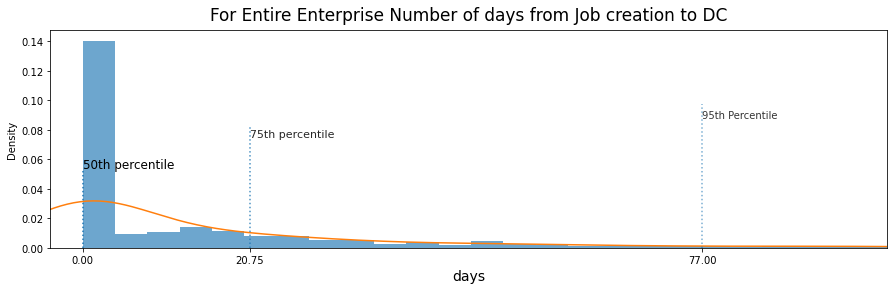

In [44]:
pay_cust_data = ets.loc[ets['dc']==1, 'time_taken_DC']
fig, ax = plt.subplots(figsize = (15,4))
pay_cust_data.plot(kind = "hist", density = True, bins = 50, alpha = 0.65)
pay_cust_data.plot(kind = "kde")
ax.set_xlim(-4, 100)
ax.set_xlabel("days" ,size=14) 
#ax.set_ylabel("SI %" ,size=14)
quant_50, quant_75, quant_95 = pay_cust_data.quantile(0.5), pay_cust_data.quantile(0.75), pay_cust_data.quantile(0.95)
quants = [[quant_50, 1, 0.36],  [quant_75, 0.8, 0.56], [quant_95, 0.6, 0.66]]
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")
    
ax.text(quant_50, 0.054, "50th percentile", size = 12, alpha = 1)
ax.text(quant_75, 0.075, "75th percentile", size = 11, alpha = 0.85)
ax.text(quant_95, 0.088, "95th Percentile", size = 10, alpha =.8)
ax.set_xticks([quant_50,quant_75, quant_95])
ax.set_title("For Entire Enterprise Number of days from Job creation to DC", size = 17, pad = 10)
plt.show()

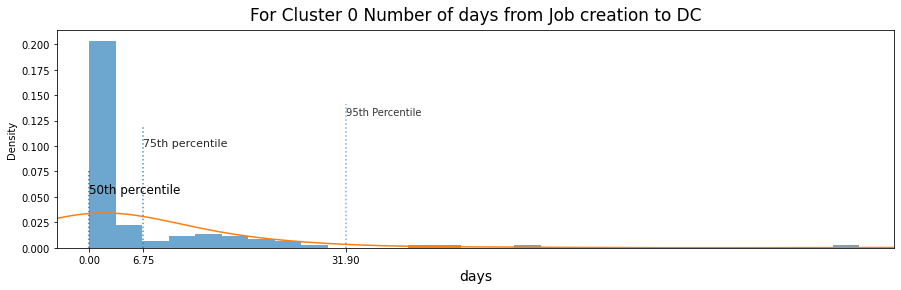

In [45]:
pay_cust_data = ets.loc[(ets['dc']==1) & (ets['cluster']==0), 'time_taken_DC']
fig, ax = plt.subplots(figsize = (15,4))
pay_cust_data.plot(kind = "hist", density = True, bins = 50, alpha = 0.65)
pay_cust_data.plot(kind = "kde")
ax.set_xlim(-4, 100)
ax.set_xlabel("days" ,size=14) 
#ax.set_ylabel("SI %" ,size=14)
quant_50, quant_75, quant_95 = pay_cust_data.quantile(0.5), pay_cust_data.quantile(0.75), pay_cust_data.quantile(0.95)
quants = [[quant_50, 1, 0.36],  [quant_75, 0.8, 0.56], [quant_95, 0.6, 0.66]]
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")
    
ax.text(quant_50, 0.054, "50th percentile", size = 12, alpha = 1)
ax.text(quant_75, 0.10, "75th percentile", size = 11, alpha = 0.85)
ax.text(quant_95, 0.13, "95th Percentile", size = 10, alpha =.8)
ax.set_xticks([quant_50,quant_75, quant_95])
ax.set_title("For Cluster 0 Number of days from Job creation to DC", size = 17, pad = 10)
plt.show()

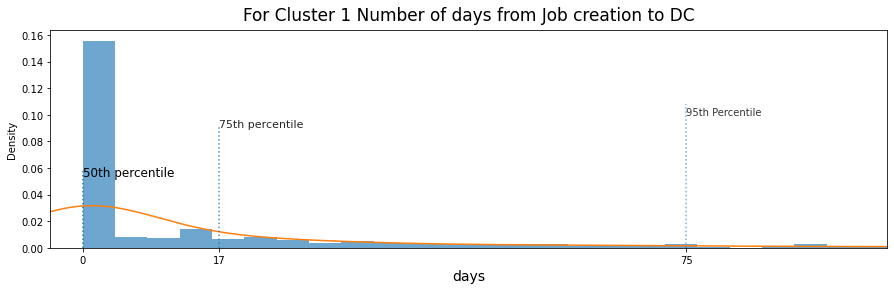

In [48]:
pay_cust_data = ets.loc[(ets['dc']==1) & (ets['cluster']==1), 'time_taken_DC']
fig, ax = plt.subplots(figsize = (15,4))
pay_cust_data.plot(kind = "hist", density = True, bins = 50, alpha = 0.65)
pay_cust_data.plot(kind = "kde")
ax.set_xlim(-4, 100)
ax.set_xlabel("days" ,size=14) 
#ax.set_ylabel("SI %" ,size=14)
quant_50, quant_75, quant_95 = pay_cust_data.quantile(0.5), pay_cust_data.quantile(0.75), pay_cust_data.quantile(0.95)
quants = [[quant_50, 1, 0.36],  [quant_75, 0.8, 0.56], [quant_95, 0.6, 0.66]]
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")
    
ax.text(quant_50, 0.054, "50th percentile", size = 12, alpha = 1)
ax.text(quant_75, 0.091, "75th percentile", size = 11, alpha = 0.85)
ax.text(quant_95, 0.10, "95th Percentile", size = 10, alpha =.8)
ax.set_xticks([quant_50,quant_75, quant_95])
ax.set_title("For Cluster 1 Number of days from Job creation to DC", size = 17, pad = 10)
plt.show()

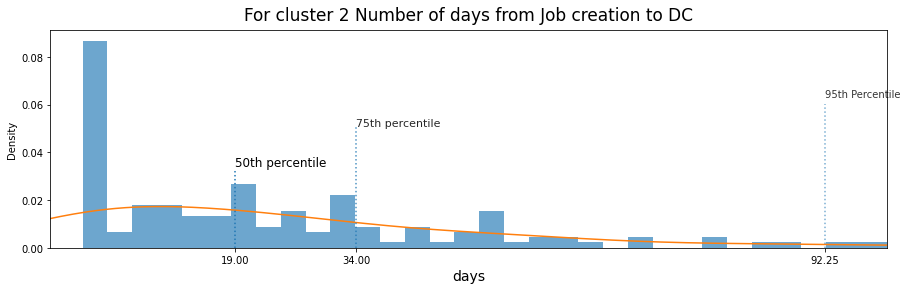

In [50]:
pay_cust_data = ets.loc[(ets['dc']==1) & (ets['cluster']==2), 'time_taken_DC']
fig, ax = plt.subplots(figsize = (15,4))
pay_cust_data.plot(kind = "hist", density = True, bins = 50, alpha = 0.65)
pay_cust_data.plot(kind = "kde")
ax.set_xlim(-4, 100)
ax.set_xlabel("days" ,size=14) 
#ax.set_ylabel("SI %" ,size=14)
quant_50, quant_75, quant_95 = pay_cust_data.quantile(0.5), pay_cust_data.quantile(0.75), pay_cust_data.quantile(0.95)
quants = [[quant_50, 1, 0.36],  [quant_75, 0.8, 0.56], [quant_95, 0.6, 0.66]]
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")
    
ax.text(quant_50, 0.034, "50th percentile", size = 12, alpha = 1)
ax.text(quant_75, 0.051, "75th percentile", size = 11, alpha = 0.85)
ax.text(quant_95, 0.063, "95th Percentile", size = 10, alpha =.8)
ax.set_xticks([quant_50,quant_75, quant_95])
ax.set_title("For cluster 2 Number of days from Job creation to DC", size = 17, pad = 10)
plt.show()